In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os

# Remaining Useful Life

## Remaining Useful Life

**The _Remaining Useful Life_ is a key concept in predictive maintenance**

The RUL refers to _the time until a component becomes unusable_

* If we can estimate the RUL of a component
* ...We can schedule maintenance operations only when they are needed

**Current best practices are based on _preventive maintenance_**

I.e. on having a _fixed maintenance schedule_ for each component family

* RUL prediction can lead to significant savings
* ...By delaying maintenance operations w.r.t. the schedule
* ...But only as long as we are still able to prevent critical failures

## The Dataset

**We will consider the NASA [C-MAPSS dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)**

* The Modular Aero-Propulsion System Simulation (MAPSS)
* ...Is a NASA-developed simulator for turbofan engines

<center><img src="assets/Turbofan3_Labelled.gif" width="45%"/></center>

* It comes with both a Military (MAPSS) and commercial versionn (C-MAPSS)
* They different in the attributes of the considered engines

## The Dataset

**The C-MAPSS system can simulate a number of faults and defects**

...And it was used to build a high-quality dataset for the PHM08 conference

* The dataset consists of 4 "training set" files and 4 "test set" files
* The _training set_ files contain multiple run-to-failure experiments
* The _test set_ files contain truncated experiments

**[PHM-08](https://phmconf.org/) hosted a competition based on this dataset**

The goal was to predict the RUL at the end of each truncated experiment

* This is fine as long as the focus is on pure prediction
* ...But we want to tackle _the whole predictive maintenance problem_

**As a consequence, we will focus only on the "training" data**

## The Dataset

**Each training file refes to different faults and operating conditions**

| Dataset | Operating conditions | Fault modes |
|  -----  |  ------------------  |  ---------  |
| FD001   | 1 (sea level)        | HPC         |
| FD002   | 6                    | HPC         |
| FD003   | 1 (sea level)        | HPC, fan    |
| FD004   | 6                    | HPC, fan    |

Fault modes refer to degration of either:

* The High Pressure Compressor
* The fan at the "mouth" of the engine

## Inspecting the Data

**Let's have a look at the row data**

In [2]:
data_folder = os.path.join('..', 'data')
data = util.load_data(data_folder)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


* Columns "p1, p2, p3" refer to controlled parameters
* Columns "s1" to "s21" refer to sensor reading
* Binning has already been applied in the original dataset

## Statistics

**Let's check some statistics**

In [4]:
dt_in = list(data.columns[3:-1]) # Exclude metadata
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


There are no missing values:

In [5]:
data[dt_in].isnull().any().any()

False

## Heatmaps

**Let's prepare for displaying all time series**

First, we standardize each column:

In [6]:
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

Then, we split our data based on the source file:

In [7]:
data_sv_dict = util.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


## Heatmaps


**Now, let's plot all parameters and sensors for _FD001_**

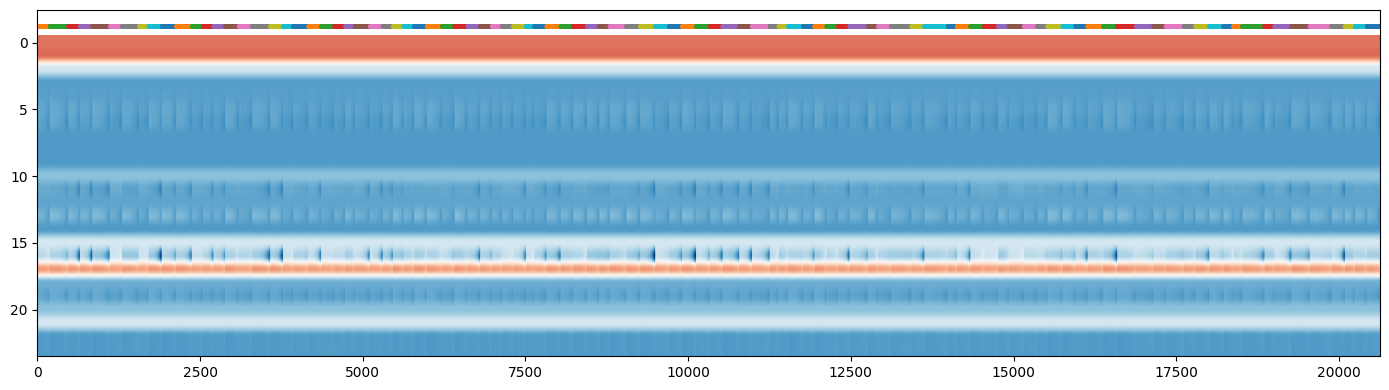

In [9]:
tmp = data_sv_dict['train_FD001']
util.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

* The data contains series for multiple machines
* These are highlighted at the top with different colors

## Heatmaps

**Now, let's plot all parameters and sensors for _FD002_**

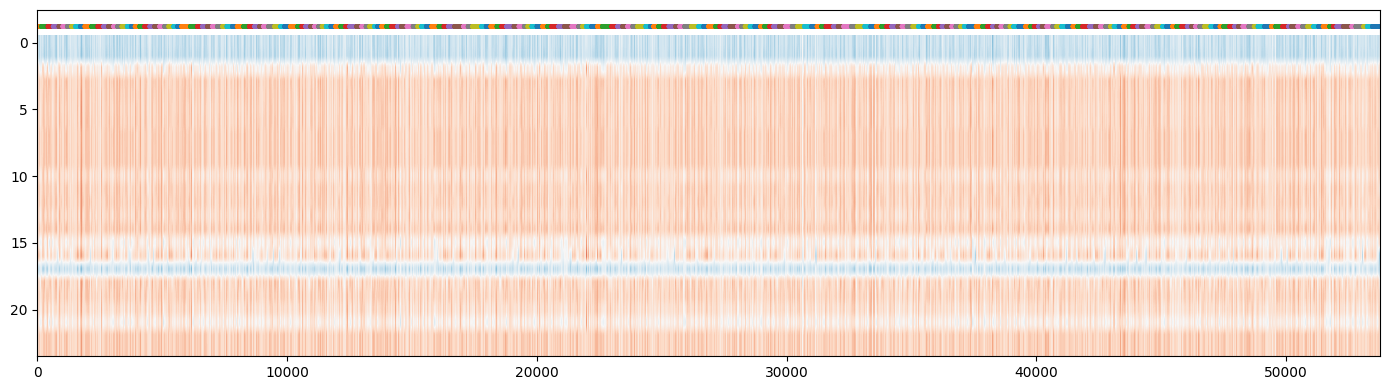

In [10]:
tmp = data_sv_dict['train_FD002']
util.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

* The series is much more variable in this case
* This is due to the multiple operating conditions

## Heatmaps

**Now, let's plot all parameters and sensors for _FD003_**

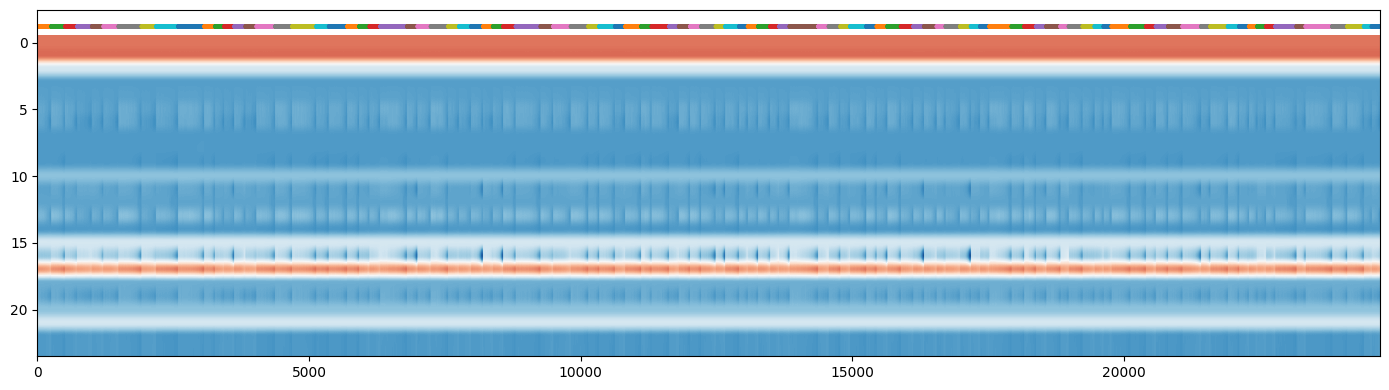

In [11]:
tmp = data_sv_dict['train_FD003']
util.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

* Only one operating condition in this case (but two fault modes)
* The series is similar to FD001

## Heatmaps

**Finally, let's plot all parameters and sensors for _FD004_**

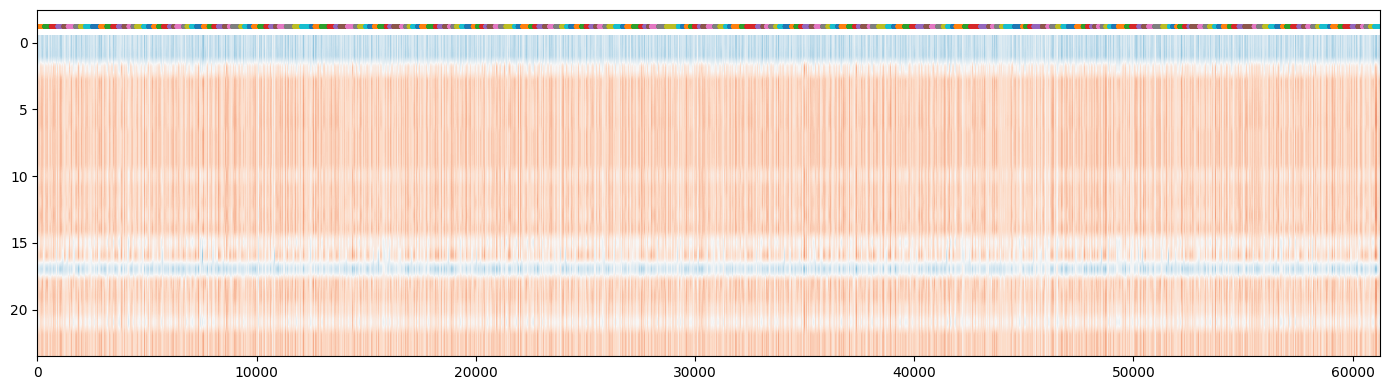

In [12]:
tmp = data_sv_dict['train_FD004']
util.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

* Again six operating conditions
* ...And the series is similar to FD004

## Selected Column

**Let's plot one column in deeper detail _for a single machine_ in _FD001_**

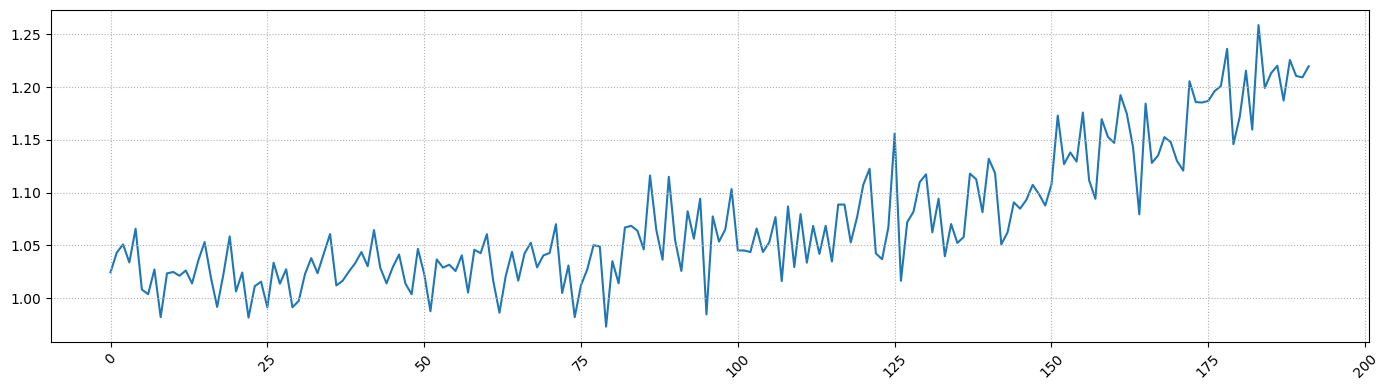

In [13]:
tmp = data_sv_dict['train_FD001']
tmp = tmp[tmp['machine'] == tmp['machine'].iloc[0]]
util.plot_series(tmp['s4'], figsize=figsize)

* A clear trend, possibly correlated to component wear

## Selected Column

**Let's see the same column for _FD002_**

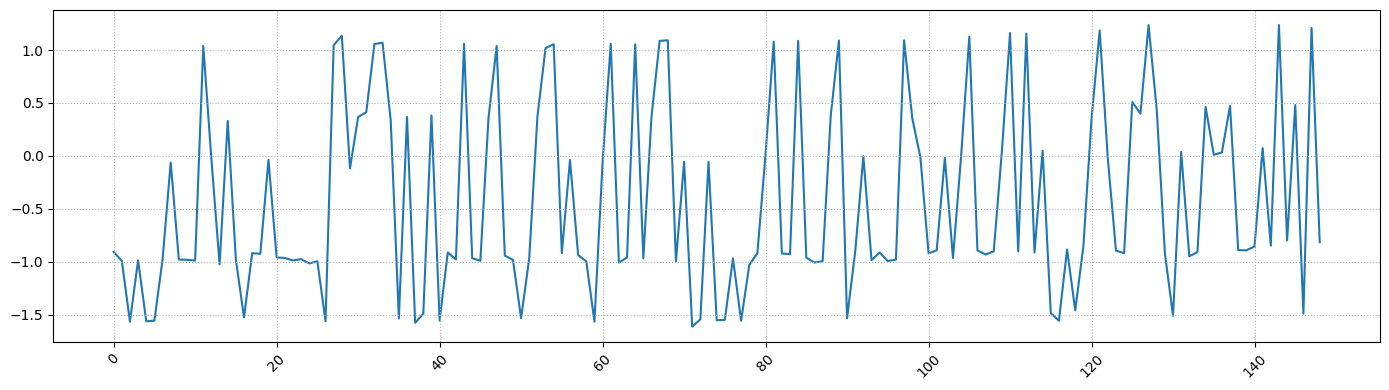

In [14]:
tmp = data_sv_dict['train_FD002']
tmp = tmp[tmp['machine'] == tmp['machine'].iloc[0]]
util.plot_series(tmp['s4'], figsize=figsize)

* The trend is still present, but weaker and hidden by wide oscillations

## Selected Column

**...And then the same column for _FD003_**

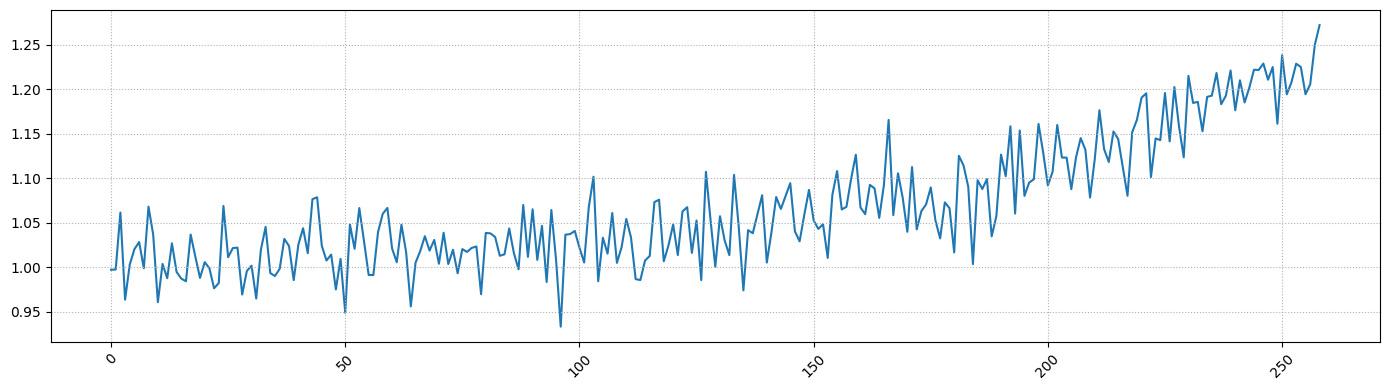

In [15]:
tmp = data_sv_dict['train_FD003']
tmp = tmp[tmp['machine'] == tmp['machine'].iloc[0]]
util.plot_series(tmp['s4'], figsize=figsize)

* Clear trend, with small oscillations that are more frequent than FD001

## Selected Column

**Let's see the same column for _FD004_**

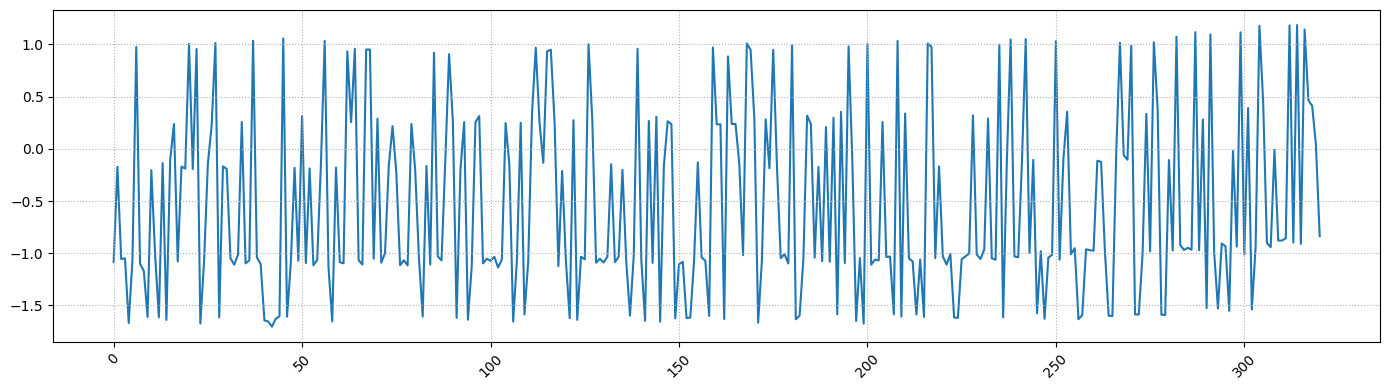

In [16]:
tmp = data_sv_dict['train_FD004']
tmp = tmp[tmp['machine'] == tmp['machine'].iloc[0]]
util.plot_series(tmp['s4'], figsize=figsize)

* Very weak trend, wide and frequent oscillations